In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Дата') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Дата') >  split_date].copy()


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями**

In [3]:
brent_data = pd.read_csv('my_BRENT2019.csv', index_col=[0])

brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [4]:
brent_data.tail()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0
2019-08-30,59.19,2019,8,30,3,242,35,4,0,0,0
2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0


In [5]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]

In [6]:
d_brent_data

array([ 0.52, -0.32,  0.05, ...,  0.53, -1.18, -0.35])

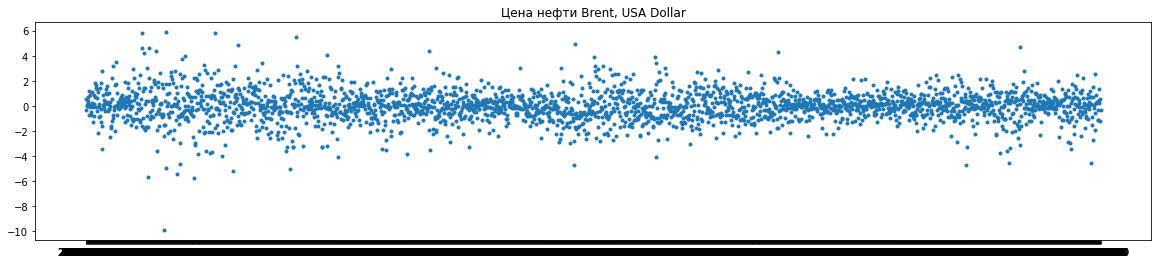

In [7]:
plt.figure(figsize=(20,4))

plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')

plt.title('Цена нефти Brent, USA Dollar')

plt.show()

**2. Добавьте первые разности по стоимости доллара и евро к рублю (можно добавить и сами курсы валют - прошлые значения)**

In [8]:
data_usd = pd.read_excel('USD.xlsx', index_col=[0])
data_eur = pd.read_excel('EUR.xlsx', index_col=[0])

In [9]:
data_eur = data_eur['2010-09-01':'2019-09-01']
data_usd = data_usd['2010-09-01':'2019-09-01']

data_usd['eur'] = data_eur.copy()

In [10]:
main_df = pd.merge(brent_data, data_usd, left_index=True, right_index=True, how = 'left')

In [11]:
main_df['eur'].fillna(method='ffill', inplace=True)
main_df['curs'].fillna(method='ffill', inplace=True)
main_df['Значение'].fillna(method='ffill', inplace=True)

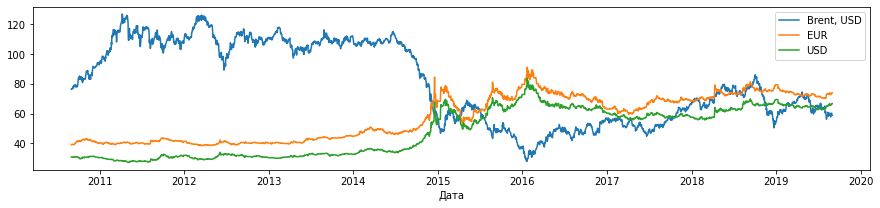

In [12]:
plt.figure( figsize=( 15, 3 ))


plt.xlabel('Дата')

plt.plot(main_df.index, main_df['Значение'], label='Brent, USD')
plt.plot(main_df.index, main_df['eur'], label='EUR' )
plt.plot(main_df.index, main_df['curs'], label='USD')


plt.legend()
plt.show()

In [13]:
main_df['d_brent'] = main_df['Значение'] - main_df['Значение'].shift(periods=1)
main_df['d_usd'] = main_df['curs'] - main_df['curs'].shift(periods=1)
main_df['d_eur'] = main_df['eur'] - main_df['eur'].shift(periods=1)

In [14]:
features = ['Значение', 'curs', 'eur', 'd_brent', 'd_usd', 'd_eur']

In [15]:
main_df = main_df[features]

In [16]:
main_df.dropna(inplace=True)

**3. сделайте ее перрасчет (ресемплинг) в представление по неделям.**

In [17]:
main_df_week = main_df.resample('1W').mean()

In [18]:
main_df_week['t1'] = main_df_week['Значение'].shift(periods=1)
main_df_week['t2'] = main_df_week['Значение'].shift(periods=2)
main_df_week['t3'] = main_df_week['Значение'].shift(periods=3)

main_df_week['curs'] = main_df_week['curs'].shift(periods=1)
main_df_week['eur'] = main_df_week['eur'].shift(periods=1)

In [19]:
main_df_week.dropna(inplace=True)

In [27]:
main_df_week

,Значение,curs,eur,d_brent,d_usd,d_eur,t1,t2,t3
Дата,,,,,,,,,
2010-09-26,78.518333,31.012233,40.967983,0.118333,-0.003200,0.203567,78.693333,77.673333,76.677500
2010-10-03,81.211667,30.607417,41.345817,0.791667,-0.081750,-0.016467,78.518333,78.693333,77.673333
2010-10-10,84.146667,30.100717,41.540667,0.106667,-0.146533,-0.013800,81.211667,78.518333,78.693333
2010-10-17,83.498333,29.921883,41.828000,-0.301667,0.049683,0.133683,84.146667,81.211667,78.518333
2010-10-24,82.795000,30.522783,42.501967,0.071667,0.133883,0.119933,83.498333,84.146667,81.211667
...,...,...,...,...,...,...,...,...,...
2019-08-04,62.791667,63.523750,70.535767,-0.286667,0.112800,0.029783,63.318333,63.778333,65.946667
2019-08-11,58.236667,64.907433,72.482783,-0.510000,0.215983,0.428417,62.791667,63.318333,63.778333
2019-08-18,59.033333,65.524150,73.232483,0.103333,0.126800,0.068633,58.236667,62.791667,63.318333


**4. Постройте модель предсказания 1-й точки от текущей (h=1).**

In [21]:
target = 'Значение'
features = ['t1', 't2', 't3', 'curs', 'eur', 'd_brent', 'd_usd', 'd_eur']

In [22]:
train, test = split_data_b(main_df_week, '2019-08-30')

In [23]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

In [24]:
h=1
X_train_b = train[features].iloc[h:]
y_train_b = train[target].values[h:]
X_test_b = test[features].iloc[-h:]
y_test_b = test[target].iloc[-h:]

In [25]:
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)


er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ошибка градиентного бустинга :   0.9738693141558251 %


In [26]:
feature_importances = pd.Series(model_gb.feature_importances_, index=X_train_b.columns)
feature_importances.sort_values(ascending=False)

curs       0.851917
t1         0.142422
d_brent    0.002552
eur        0.001357
d_usd      0.000620
d_eur      0.000426
t2         0.000396
t3         0.000311
dtype: float64